In [ ]:
!pip install kaggle

# Replace with your actual Kaggle API key and username
import os
os.environ['KAGGLE_USERNAME'] = "YOUR_KAGGLE_USERNAME"
os.environ['KAGGLE_KEY'] = "YOUR_KAGGLE_KEY"

!kaggle datasets download -d stanfordu/stanford-question-answering-dataset

!unzip stanford-question-answering-dataset.zip

!rm stanford-question-answering-dataset.zip

print('Data source import complete.')

Dataset URL: https://www.kaggle.com/datasets/stanfordu/stanford-question-answering-dataset
License(s): CC-BY-SA-4.0
  0% 0.00/8.73M [00:00<?, ?B/s]
100% 8.73M/8.73M [00:00<00:00, 1.04GB/s]
Archive:  stanford-question-answering-dataset.zip
  inflating: dev-v1.1.json           
  inflating: train-v1.1.json         
Data source import complete.


In [ ]:
!pip install transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json
from transformers import (
    TFAutoModelForQuestionAnswering,
    AutoTokenizer,
    DefaultDataCollator,
    create_optimizer
)
from datasets import Dataset, DatasetDict
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

## Initialize Model and Tokenizer

In [ ]:
model_checkpoint = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForQuestionAnswering.from_pretrained(model_checkpoint, from_pt=True)
print(f"number of parameters: {model.count_params():,}")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForQuestionAnswering: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForQuestionAnswering from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForQuestionAnswering from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForQuestionAnswering were not initialized from the PyTorch model and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream

number of parameters: 66,364,418


## Load and Explore SQuAD Dataset from Kaggle Files


In [ ]:
# Load the JSON files
with open('/content/train-v1.1.json', 'r') as f:
    train_data = json.load(f)

with open('/content/dev-v1.1.json', 'r') as f:
    dev_data = json.load(f)

# Function to convert SQuAD format to flat structure
def squad_json_to_dataframe(squad_data):
    contexts = []
    questions = []
    answers = []
    ids = []

    for article in squad_data['data']:
        for paragraph in article['paragraphs']:
            context = paragraph['context']
            for qa in paragraph['qas']:
                contexts.append(context)
                questions.append(qa['question'])
                ids.append(qa['id'])

                # Handle answers
                if qa.get('answers'):
                    answer_starts = [answer['answer_start'] for answer in qa['answers']]
                    answer_texts = [answer['text'] for answer in qa['answers']]
                    answers.append({
                        'text': answer_texts,
                        'answer_start': answer_starts
                    })
                else:
                    answers.append({
                        'text': [],
                        'answer_start': []
                    })

    return {
        'id': ids,
        'context': contexts,
        'question': questions,
        'answers': answers
    }

# Convert to dataframes
train_df = squad_json_to_dataframe(train_data)
dev_df = squad_json_to_dataframe(dev_data)

# Reduce size for debugging/training small model
MAX_TRAIN_SAMPLES = 10000   # Giảm xuống tùy ý
MAX_DEV_SAMPLES = 1000

# Cắt bớt mẫu
for key in train_df:
    train_df[key] = train_df[key][:MAX_TRAIN_SAMPLES]

for key in dev_df:
    dev_df[key] = dev_df[key][:MAX_DEV_SAMPLES]

# Create datasets
dataset = DatasetDict({
    'train': Dataset.from_dict(train_df),
    'validation': Dataset.from_dict(dev_df)
})

# Display dataset info
print("Dataset Structure:")
print(dataset)
print("\nTraining examples:", len(dataset['train']))
print("Validation examples:", len(dataset['validation']))

# Display sample data
print("\nSample training example:")
sample = dataset['train'][0]
print(f"Context: {sample['context'][:200]}...")
print(f"Question: {sample['question']}")
print(f"Answer: {sample['answers']}")

Dataset Structure:
DatasetDict({
    train: Dataset({
        features: ['id', 'context', 'question', 'answers'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['id', 'context', 'question', 'answers'],
        num_rows: 1000
    })
})

Training examples: 10000
Validation examples: 1000

Sample training example:
Context: Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper sta...
Question: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Answer: {'answer_start': [515], 'text': ['Saint Bernadette Soubirous']}


## Preprocessing

In [ ]:
max_length = 384
doc_stride = 128

def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    offset_mapping = inputs.pop("offset_mapping")

    inputs["start_positions"] = []
    inputs["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = examples["answers"][sample_idx]

        if len(answer["answer_start"]) == 0:
            inputs["start_positions"].append(0)
            inputs["end_positions"].append(0)
        else:
            start_char = answer["answer_start"][0]
            end_char = start_char + len(answer["text"][0])

            sequence_ids = inputs.sequence_ids(i)

            # Find the start and end of the context
            idx = 0
            while sequence_ids[idx] != 1:
                idx += 1
            context_start = idx
            while sequence_ids[idx] == 1:
                idx += 1
            context_end = idx - 1

            # If the answer is not in this span, label is (0, 0)
            if offsets[context_start][0] > start_char or offsets[context_end][1] < end_char:
                inputs["start_positions"].append(0)
                inputs["end_positions"].append(0)
            else:
                # Otherwise find the start and end token positions
                idx = context_start
                while idx <= context_end and offsets[idx][0] <= start_char:
                    idx += 1
                inputs["start_positions"].append(idx - 1)

                idx = context_end
                while idx >= context_start and offsets[idx][1] >= end_char:
                    idx -= 1
                inputs["end_positions"].append(idx + 1)

    return inputs

def preprocess_validation_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

## Prepare Datasets

In [ ]:
tokenized_train = dataset["train"].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=dataset["train"].column_names,
    num_proc=2
)

tokenized_validation = dataset["validation"].map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=dataset["validation"].column_names,
    num_proc=2
)

data_collator = DefaultDataCollator(return_tensors="tf")

train_dataset = tokenized_train.to_tf_dataset(
    columns=["input_ids", "attention_mask", "start_positions", "end_positions"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

validation_dataset = tokenized_validation.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

print("Training batches:", len(train_dataset))
print("Validation batches:", len(validation_dataset))

Map (num_proc=2):   0%|          | 0/10000 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/1000 [00:00<?, ? examples/s]

Training batches: 634
Validation batches: 64


## Training Setup

In [ ]:
num_train_epochs = 2
batch_size = 16
num_train_steps = len(train_dataset) * num_train_epochs

optimizer, lr_schedule = create_optimizer(
    init_lr=5e-5,
    num_train_steps=num_train_steps,
    num_warmup_steps=int(0.1 * num_train_steps),
)

model.compile(optimizer=optimizer)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=2,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='loss',
        factor=0.5,
        patience=1,
        min_lr=1e-7
    )
]

## Train Model

In [ ]:
history = model.fit(
    train_dataset,
    epochs=num_train_epochs,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/2
634/634 [==============================] - 483s 723ms/step - loss: 2.3760 - lr: 2.7802e-05
Epoch 2/2
634/634 [==============================] - 458s 722ms/step - loss: 0.9768 - lr: 4.3783e-08


## Plot training history

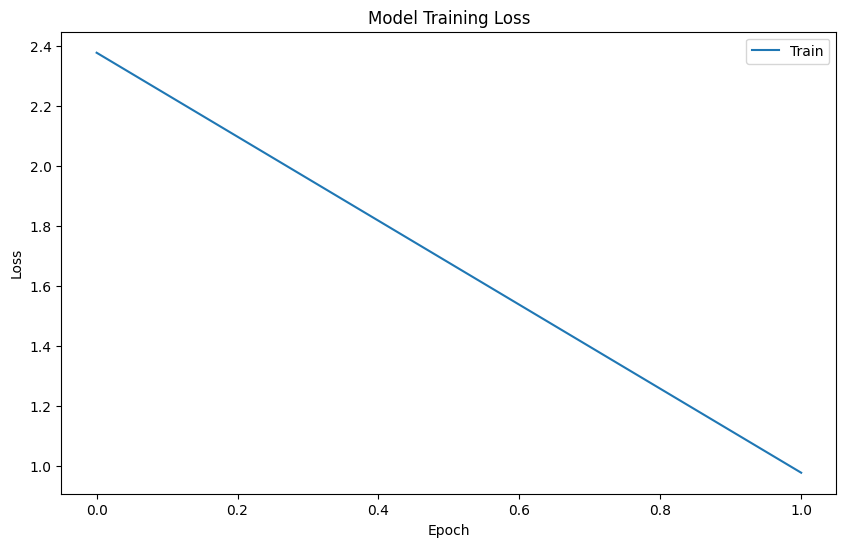

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train'], loc='upper right')
plt.show()

## Evaluation Functions

In [ ]:
def compute_metrics(start_logits, end_logits, features, examples):
    example_to_features = {}
    for idx, feature in enumerate(features):
        if feature["example_id"] not in example_to_features:
            example_to_features[feature["example_id"]] = []
        example_to_features[feature["example_id"]].append(idx)

    n_best = 20
    max_answer_length = 30
    predicted_answers = []

    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()

            for start_index in start_indexes:
                for end_index in end_indexes:
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    answers.append({
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    })

        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append({
                "id": example_id,
                "prediction_text": best_answer["text"]
            })
        else:
            predicted_answers.append({
                "id": example_id,
                "prediction_text": ""
            })

    theoretical_answers = [
        {"id": ex["id"], "answers": ex["answers"]} for ex in examples
    ]

    return predicted_answers, theoretical_answers

In [ ]:
# Get predictions
print("Getting predictions...")
outputs = model.predict(validation_dataset)
start_logits = outputs.start_logits
end_logits = outputs.end_logits

# Compute predictions
predictions, references = compute_metrics(
    start_logits,
    end_logits,
    tokenized_validation,
    dataset["validation"]
)

# Calculate metrics manually (Exact Match and F1)
def compute_exact_match(prediction, ground_truth):
    return int(prediction.strip().lower() == ground_truth.strip().lower())

def compute_f1(prediction, ground_truth):
    pred_tokens = prediction.strip().lower().split()
    truth_tokens = ground_truth.strip().lower().split()

    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)

    common_tokens = set(pred_tokens) & set(truth_tokens)

    if len(common_tokens) == 0:
        return 0

    precision = len(common_tokens) / len(pred_tokens)
    recall = len(common_tokens) / len(truth_tokens)

    return 2 * (precision * recall) / (precision + recall)

# Calculate scores
total_em = 0
total_f1 = 0
total_count = 0

for pred, ref in zip(predictions, references):
    prediction_text = pred["prediction_text"]
    ground_truths = ref["answers"]["text"]

    if ground_truths:
        # Calculate best scores against all possible answers
        em_scores = [compute_exact_match(prediction_text, gt) for gt in ground_truths]
        f1_scores = [compute_f1(prediction_text, gt) for gt in ground_truths]

        total_em += max(em_scores)
        total_f1 += max(f1_scores)
        total_count += 1

# Final metrics
exact_match = (total_em / total_count) * 100
f1_score = (total_f1 / total_count) * 100

print(f"\nEvaluation Results:")
print(f"Exact Match: {exact_match:.2f}%")
print(f"F1 Score: {f1_score:.2f}%")

Getting predictions...
64/64 [==============================] - 16s 225ms/step


100%|██████████| 1000/1000 [00:01<00:00, 701.13it/s]



Evaluation Results:
Exact Match: 66.60%
F1 Score: 74.23%


In [ ]:
def answer_question(question, context, model, tokenizer):
    # Tokenize
    inputs = tokenizer(
        question,
        context,
        max_length=384,
        truncation="only_second",
        return_tensors="tf",
        padding="max_length"
    )

    # Get predictions
    outputs = model(inputs)
    start_logits = outputs.start_logits[0]
    end_logits = outputs.end_logits[0]

    # Get the most likely tokens
    start_index = tf.argmax(start_logits, axis=-1).numpy()
    end_index = tf.argmax(end_logits, axis=-1).numpy()

    # Convert tokens to answer
    predict_answer_tokens = inputs.input_ids[0, start_index : end_index + 1]
    answer = tokenizer.decode(predict_answer_tokens, skip_special_tokens=True)

    return answer

# Test with examples
test_examples = [
    {
        "context": "The Eiffel Tower is a wrought-iron lattice tower on the Champ de Mars in Paris, France. It is named after the engineer Gustave Eiffel, whose company designed and built the tower. Constructed from 1887 to 1889, it was initially criticized by some of France's leading artists and intellectuals.",
        "question": "When was the Eiffel Tower built?"
    },
    {
        "context": "Machine learning is a branch of artificial intelligence (AI) and computer science which focuses on the use of data and algorithms to imitate the way that humans learn, gradually improving its accuracy. IBM has a rich history with machine learning.",
        "question": "What is machine learning?"
    }
]

print("Interactive Question Answering Examples:\n")
for example in test_examples:
    answer = answer_question(example["question"], example["context"], model, tokenizer)
    print(f"Context: {example['context'][:100]}...")
    print(f"Question: {example['question']}")
    print(f"Answer: {answer}")
    print("-" * 80 + "\n")

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


Interactive Question Answering Examples:

Context: The Eiffel Tower is a wrought-iron lattice tower on the Champ de Mars in Paris, France. It is named ...
Question: When was the Eiffel Tower built?
Answer: 1887 to 1889
--------------------------------------------------------------------------------

Context: Machine learning is a branch of artificial intelligence (AI) and computer science which focuses on t...
Question: What is machine learning?
Answer: artificial intelligence ( ai ) and computer science
--------------------------------------------------------------------------------



In [ ]:
# Function to evaluate different models
def evaluate_model(model_name, dataset):
    print(f"\nEvaluating {model_name}...")

    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = TFAutoModelForQuestionAnswering.from_pretrained(model_name)

    # Preprocess validation data
    tokenized_val = dataset["validation"].map(
        lambda x: preprocess_validation_examples(x),
        batched=True,
        remove_columns=dataset["validation"].column_names,
        num_proc=2
    )

    # Convert to TF dataset
    val_dataset = tokenized_val.to_tf_dataset(
        columns=["input_ids", "attention_mask"],
        shuffle=False,
        batch_size=16,
        collate_fn=data_collator,
    )

    # Get predictions
    outputs = model.predict(val_dataset)
    predictions, _ = compute_metrics(
        outputs.start_logits,
        outputs.end_logits,
        tokenized_val,
        dataset["validation"]
    )

    return model_name, predictions

# Compare different models (this will take time)
models_to_compare = [
    "distilbert-base-uncased",
    "bert-base-uncased",
    # Add more models as needed, but be aware of memory limitations
]

print("Comparing different models...")
results = {}

for model_name in models_to_compare:
    try:
        name, predictions = evaluate_model(model_name, dataset)
        # Calculate metrics for this model
        # (Add metric calculation here similar to Cell 9)
        results[name] = predictions
        print(f"✓ {model_name} evaluation complete")
    except Exception as e:
        print(f"✗ Error with {model_name}: {e}")

Comparing different models...

Evaluating distilbert-base-uncased...


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

✗ Error with distilbert-base-uncased: 'builtins.safe_open' object is not iterable

Evaluating bert-base-uncased...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

✗ Error with bert-base-uncased: 'builtins.safe_open' object is not iterable


In [ ]:
# Save the model
model.save_pretrained("./squad_qa_model")
tokenizer.save_pretrained("./squad_qa_model")
print("Model saved")

Model saved


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
